<center>
<img src="https://habrastorage.org/web/677/8e1/337/6778e1337c3d4b159d7e99df94227cb2.jpg"/>
## Специализация "Машинное обучение и анализ данных"
<center>Автор материала: программист-исследователь Mail.Ru Group, старший преподаватель Факультета Компьютерных Наук ВШЭ [Юрий Кашницкий](https://yorko.github.io/)

# <center>  Capstone проект №1 <br> Идентификация пользователей по посещенным веб-страницам
<img src='http://i.istockimg.com/file_thumbview_approve/21546327/5/stock-illustration-21546327-identification-de-l-utilisateur.jpg'>

# <center>Неделя 3. Визуальный анализ данных и построение признаков

На 3 неделе мы займемся визуальным анализом данных и построением признаков. Сначала мы вместе построим и проанализируем несколько признаков, потом Вы сможете сами придумать и описать различные признаки. 

**План 3 недели:**
 - Часть 1. Построение признаков
 - Часть 2. Визуальный анализ данных
 - Часть 3. Дальнейшее построение признаков
 - Часть 4. Проверка построенных признаков

**В этой части проекта Вам могут быть полезны видеозаписи следующих лекций курса "Поиск структуры в данных":**
   - [Задача визуализации](https://www.coursera.org/learn/unsupervised-learning/lecture/hlvlT/zadacha-vizualizatsii)
   - [Визуализация данных в sklearn](https://www.coursera.org/learn/unsupervised-learning/lecture/ityMo/vizualizatsiia-dannykh-v-sklearn)
   
**Также в задании будет использоваться библиотека Seaborn (ее можно дополнительно установить командой *pip install seaborn*), будет полезно обращаться к документациям [Matplotlib](http://matplotlib.org/users/) и [Seaborn](http://seaborn.pydata.org/), а также к примерам визуализации, описанным на StackOverflow.**



### Задание
1. Заполните код в этой тетрадке 
2. Если вы проходите специализацию Яндеса и МФТИ, пошлите тетрадку в соответствующем Peer Review. <br> Если вы проходите курс ODS, выберите ответы в [веб-форме](https://docs.google.com/forms/d/1EbjK7-hF-Gepi6RH-K5I2XeiYGRoY0LNDx03QmLu9Xo). 

## Часть 1. Построение признаков

In [1]:
from __future__ import division, print_function
# отключим всякие предупреждения Anaconda
import warnings
warnings.filterwarnings('ignore')
from glob import glob
import os
from tqdm import tqdm_notebook, tqdm
import numpy as np
import pandas as pd
pd.set_option('display.max.columns', 25)
import pickle
#pip install seaborn
import seaborn as sns
%matplotlib inline
from matplotlib import pyplot as plt
from datetime import datetime


In [2]:
# Поменяйте на свой путь к данным
PATH_TO_DATA = 'data/capstone_user_identification'

**Создайте на основе функций *prepare_train_set* и *prepare_sparse_train_set_window*  новую – *prepare_train_set_with_fe*, (от "feature engineering"), создайте следующие признаки:**
- `session_timespan` – продолжительность сессии (разница между максимальным и минимальным временем посещения сайтов в сессии, в секундах)
- `#unique_sites` – число уникальных сайтов в сессии 
- `start_hour` – час начала сессии (то есть час в записи минимального timestamp среди десяти)
- `day_of_week` – день недели (то есть день недели в записи минимального timestamp среди десяти)

Функция должна возвращать новый DataFrame (как возвращала функция *prepare_train_set*), только признаков должно быть на 4 больше. Порядок, в котором добавляются признаки: *site1*, ... *site10*, *session_timespan*, *#unique_sites*, *start_hour*, *day_of_week* и *user_id* (это видно и чуть ниже по тому, как функция вызывается).

In [3]:
def prepare_train_set_with_fe(path_to_csv_files, site_freq_path, feature_names,
                                    session_length=10, window_size=10):
    site_freq = None
    with open(site_freq_path, 'rb') as f:
        site_freq = pickle.load(f)
        
    data = []
    
    files_list = sorted(glob(os.path.join(path_to_csv_files, '*.csv')))
    for file in tqdm(files_list):
        
        user_id = int(os.path.basename(file).split('.')[0][4:])
        sites = []
        timestamps = []
        
        with open(file, 'r') as f:
            
            for line in f:
                row = line.strip().split(',')
                if len(row) != 2:
                    continue
                time, site = row[0], row[1]
                
                if site == 'site':
                    continue
                    
                
                sites.append(site_freq[site][0])
                timestamps.append(datetime.fromisoformat(time))
            
            
            n = len(sites)
            index = 0
            while True:
                if (index + session_length) > n+1:
                    slc = sites[index:] + [0]*((index+session_length) - (n+1) + 1)
                    #time_slc = timestamps[index:] + [0]*((index+session_length) - (n+1))
                else:
                    slc = sites[index:index+session_length]
                    
                if sum(slc) == 0:
                    break
                    
                time_slc = timestamps[index:index+session_length]
                session_time = (max(time_slc) - min(time_slc)).total_seconds()
                unique_sites = len(set([i for i in slc if i != 0]))
                start_hour = min(time_slc).hour
                day_of_week = min(time_slc).weekday()
                
                time_diff = []
                for i in range(1, session_length):
                    if i >= len(time_slc):
                        time_diff.append(0)
                    else:
                        time_diff.append((time_slc[i] - time_slc[i-1]).total_seconds())
                
                slc = slc + time_diff
                slc = slc + [session_time, unique_sites, start_hour, day_of_week, user_id]
                
                data.append(slc)
                
                
                index += window_size
                if index > n:
                    break
                    
                    

    df = pd.DataFrame(data, columns=feature_names)
    return df

In [4]:
feature_names = ['site' + str(i) for i in range(1,11)] + \
                ['time_diff' + str(j) for j in range(1,10)] + \
                ['session_timespan', '#unique_sites', 'start_hour', 
                 'day_of_week', 'target']
train_data_toy  = prepare_train_set_with_fe(os.path.join(PATH_TO_DATA, 
                                                         '3users'), 
                  site_freq_path=os.path.join(PATH_TO_DATA, 
                                              'site_freq_3users.pkl'),
                  feature_names=feature_names, session_length=10)

100%|██████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 2997.36it/s]


In [5]:
train_data_toy

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10,time_diff1,time_diff2,time_diff3,time_diff4,time_diff5,time_diff6,time_diff7,time_diff8,time_diff9,session_timespan,#unique_sites,start_hour,day_of_week,target
0,1,2,2,3,2,4,5,6,7,8,287.0,1184.0,6278.0,186.0,2.0,1.0,2.0,3.0,55.0,7998.0,8,9,4,1
1,1,4,4,4,0,0,0,0,0,0,2.0,3.0,55.0,0.0,0.0,0.0,0.0,0.0,0.0,60.0,2,12,4,1
2,1,2,9,9,2,0,0,0,0,0,287.0,1184.0,6278.0,186.0,0.0,0.0,0.0,0.0,0.0,7935.0,3,9,4,2
3,10,4,2,4,2,4,4,6,11,10,287.0,1184.0,6278.0,186.0,2.0,1.0,2.0,3.0,55.0,7998.0,5,9,4,3
4,10,4,2,0,0,0,0,0,0,0,287.0,1184.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1471.0,3,12,4,3


**Проверим функцию на игрушечном примере.**

**Примените функцию *prepare_train_set_with_fe* к данным по 10 пользователям, укажите *session_length*=10.**

In [6]:
%%time

session_length=10

feature_names = ['site' + str(i) for i in range(1,session_length+1)] + \
                ['time_diff' + str(j) for j in range(1,session_length)] + \
                ['session_timespan', '#unique_sites', 'start_hour', 
                 'day_of_week', 'target']
train_data_10users  = prepare_train_set_with_fe(os.path.join(PATH_TO_DATA, 
                                                         '10users'.format(session_length)), 
                  site_freq_path=os.path.join(PATH_TO_DATA, 
                                              'site_freq_10users.pkl'.format(session_length)),
                  feature_names=feature_names, session_length=session_length)

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 47.62it/s]

Wall time: 267 ms


In [7]:
train_data_10users.head()

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10,time_diff1,time_diff2,time_diff3,time_diff4,time_diff5,time_diff6,time_diff7,time_diff8,time_diff9,session_timespan,#unique_sites,start_hour,day_of_week,target
0,1,2,3,4,3,3,4,3,5,3.0,10.0,0.0,0.0,1.0,20.0,1.0,0.0,1.0,0.0,33.0,5,8,4,31.0
1,6,7,8,9,3,10,11,12,13,14.0,1.0,0.0,163.0,105.0,0.0,1.0,3.0,3.0,8.0,284.0,10,8,4,31.0
2,14,4,14,14,15,16,6,17,18,14.0,0.0,14.0,1.0,242.0,0.0,0.0,1.0,0.0,0.0,258.0,7,8,4,31.0
3,19,20,19,14,14,14,14,21,22,23.0,2.0,1.0,0.0,1.0,25.0,1.0,0.0,0.0,0.0,30.0,6,8,4,31.0
4,24,14,15,25,26,27,28,29,30,29.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,6.0,9,8,4,31.0


**Примените функцию *prepare_train_set_with_fe* к данным по 150 пользователям, укажите *session_length*=10.**

In [8]:
%%time

session_length=10

feature_names = ['site' + str(i) for i in range(1,session_length+1)] + \
                ['time_diff' + str(j) for j in range(1,session_length)] + \
                ['session_timespan', '#unique_sites', 'start_hour', 
                 'day_of_week', 'target']

train_data_150users  = prepare_train_set_with_fe(os.path.join(PATH_TO_DATA, 
                                                         '150users'), 
                  site_freq_path=os.path.join(PATH_TO_DATA, 
                                              'site_freq_150users.pkl'),
                  feature_names=feature_names, session_length=session_length)


100%|████████████████████████████████████████████████████████████████████████████████| 150/150 [00:02<00:00, 73.78it/s]


Wall time: 2.54 s


**Сохраните в pickle-файлы признаки *session_timespan*, *#unique_sites*, *start_hour* и *day_of_week* для 10 и 150 пользователей.**

In [10]:
columns = ['time_diff' + str(j) for j in range(1,10)] + \
            ['session_timespan', '#unique_sites', 'start_hour', 'day_of_week']


new_features_10users = train_data_10users[columns]
new_features_150users = train_data_150users[columns]

In [11]:
with open(os.path.join(PATH_TO_DATA, 
                       'new_features_10users.pkl'), 'wb') as new_features_10users_pkl:
    pickle.dump(new_features_10users, new_features_10users_pkl)
with open(os.path.join(PATH_TO_DATA, 
                       'new_features_150users.pkl'), 'wb') as new_features_150users_pkl:
    pickle.dump(new_features_150users, new_features_150users_pkl)

**<font color='red'>Вопрос 1. </font> Выведите медианную продолжительность сессии (*session_timespan*) для сессий 10 пользователей.**

In [12]:
''' ВАШ КОД ЗДЕСЬ ''' 

print('Медианная продолжительность сессии: {}'.format(train_data_10users['session_timespan'].median()))

Медианная продолжительность сессии: 37.0


**<font color='red'>Вопрос 2. </font> Выведите медианный день недели, в который началась сессия, для сессий 10 пользователей.**

In [13]:
''' ВАШ КОД ЗДЕСЬ ''' 

print('Медианный день недели: {}'.format(train_data_10users['day_of_week'].median()))

Медианный день недели: 2.0


**<font color='red'>Вопрос 3. </font>Выведите медианный час начала сессии для сессий 150 пользователей.**

In [14]:
''' ВАШ КОД ЗДЕСЬ ''' 

print('Медианный час: {}'.format(train_data_150users['start_hour'].median()))

Медианный час: 13.0


**<font color='red'>Вопрос 4. </font>Выведите медианное значение числа уникальных сайтов в сессиях 150 пользователей.**

In [15]:
''' ВАШ КОД ЗДЕСЬ '''

print('Медианное значение числа уникальных сайтов: {}'.format(train_data_150users['#unique_sites'].median()))

Медианное значение числа уникальных сайтов: 7.0


## Часть 2. Визуальный анализ данных

**Забавы ради, потехи для дадим пользователям имена и ассоциируем с ними цвета.**

In [16]:
id_name_dict = {128: 'Mary-Kate', 39: 'Ashley', 207: 'Lindsey', 127: 'Naomi', 237: 'Avril',
               33: 'Bob', 50: 'Bill', 31: 'John', 100: 'Dick', 241: 'Ed'}
train_data_10users['target'] = train_data_10users['target'].map(id_name_dict)

In [17]:
color_dic = {'Mary-Kate': 'pink', 'Ashley': 'darkviolet', 'Lindsey':'blueviolet', 
             'Naomi': 'hotpink', 'Avril': 'orchid', 
             'Bob': 'firebrick', 'Bill': 'gold', 'John': 'forestgreen', 
             'Dick': 'slategrey', 'Ed':'brown'}

**1. Постройте гистограмму распределения длины сессии в секундах (*session_timespan*). Ограничьте по *x* значением 200 (иначе слишком тяжелый хвост). Сделайте гистограмму цвета *darkviolet*, подпишите оси по-русски.**

array([[<AxesSubplot:title={'center':'session_timespan'}>]], dtype=object)

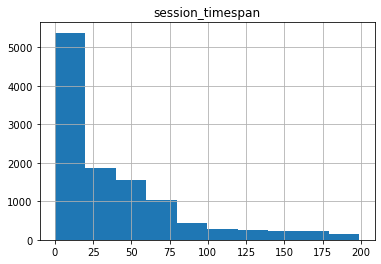

In [18]:
train_data_10users[train_data_10users['session_timespan'] < 200].hist('session_timespan')

**2. Постройте гистограмму распределения числа уникальных сайтов в сессии (*#unique_sites*). Сделайте гистограмму цвета *aqua*, подпишите оси по-русски.**

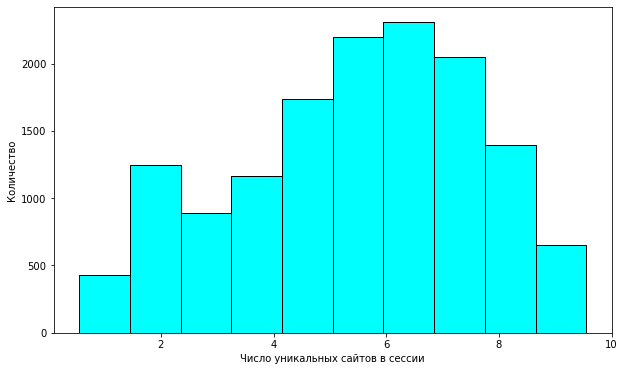

In [22]:
plt.figure(figsize=(10, 6))
plt.hist(train_data_10users['#unique_sites'], color='aqua', edgecolor='black', align='left')
plt.xlabel(u'Число уникальных сайтов в сессии')
plt.ylabel(u'Количество');

**3. Постройте гистограммы распределения числа уникальных сайтов в сессии (*#unique_sites*) для каждого из 10 пользователей по отдельности. Используйте *subplots*, чтоб разместить все 10 картинок на одной большой. Пометьте легендой каждую картинку, на легенде должно быть написано имя пользователя. Для каждого пользователя раскрасьте гистограмму его/ее цветом (*color_dic*). Подпишите оси по-русски в каждой из 10 гистограмм.**

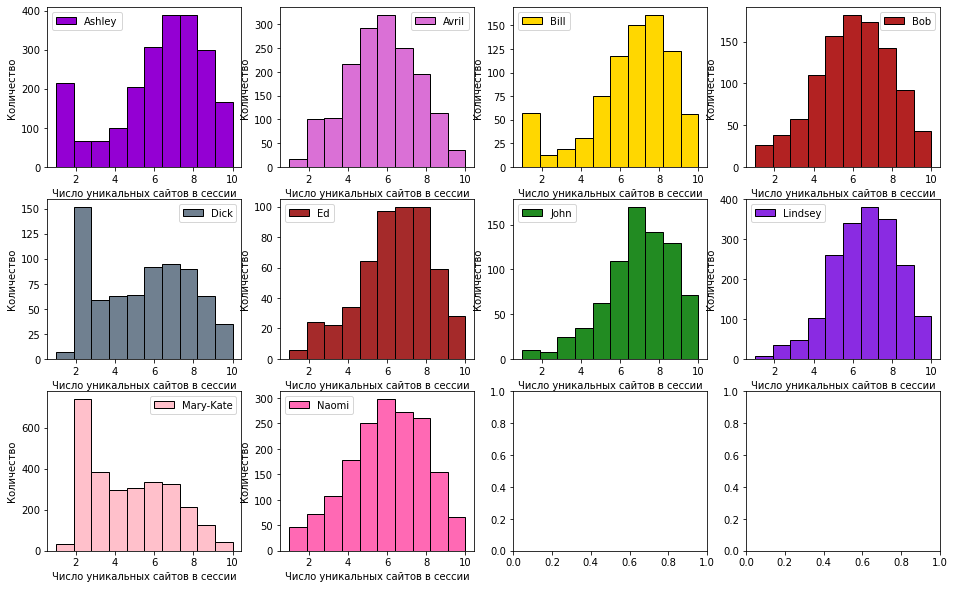

In [43]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 10))
row, column = 0, 0
# как вариант, можно и по-другому
for idx, (user, sub_df) in  enumerate(train_data_10users.groupby(['target'])): 
    axes[row, column].hist(sub_df['#unique_sites'], color=color_dic[user], edgecolor='black')
    axes[row, column].set_xlabel(u'Число уникальных сайтов в сессии')
    axes[row, column].set_ylabel(u'Количество')
    axes[row, column].legend([user])
    
    column += 1
    if column == 4:
        column = 0
        row += 1

**4. Постройте гистограмму распределения часа начала сессии (*start_hour*). Сделайте гистограмму цвета *darkgreen*, подпишите оси по-русски.**

Text(0, 0.5, 'Количество')

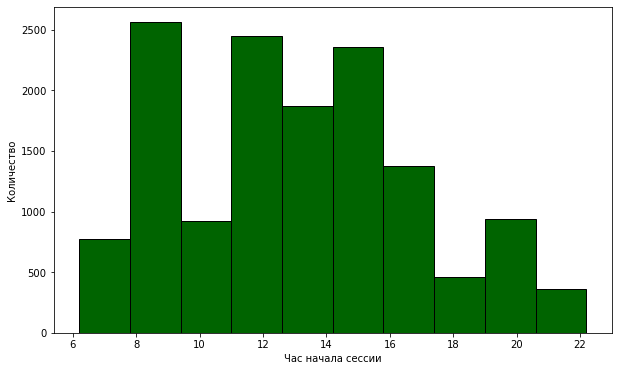

In [42]:
plt.figure(figsize=(10, 6))
plt.hist(train_data_10users['start_hour'], color='darkgreen', align='left', edgecolor='black')
plt.xlabel(u'Час начала сессии')
plt.ylabel(u'Количество')

**5. Постройте гистограммы распределения часа начала сессии (*start_hour*) для каждого из 10 пользователей по отдельности. Используйте *subplots*, чтоб разместить все 10 картинок на одной большой. Пометьте легендой каждую картинку, на легенде должно быть написано имя пользователя. Для каждого пользователя раскрасьте гистограмму его/ее цветом (*color_dic*). Подпишите оси по-русски в каждой из 10 гистограмм.**

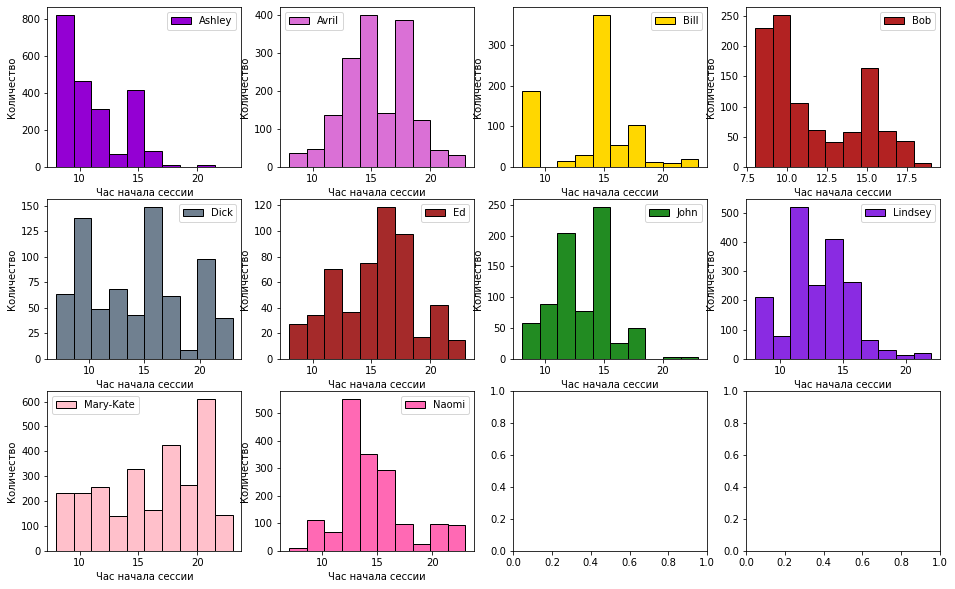

In [41]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 10))
row, column = 0, 0
# как вариант, можно и по-другому
for idx, (user, sub_df) in  enumerate(train_data_10users.groupby(['target'])): 
    axes[row, column].hist(sub_df['start_hour'], color=color_dic[user], edgecolor='black')
    axes[row, column].set_xlabel(u'Час начала сессии')
    axes[row, column].set_ylabel(u'Количество')
    axes[row, column].legend([user])
    
    column += 1
    if column == 4:
        column = 0
        row += 1

**6. Постройте гистограмму распределения дня недели, в который началась сессия (*day_of_week*). Сделайте гистограмму цвета *sienna*, подпишите оси по-русски.**

Text(0, 0.5, 'Количество')

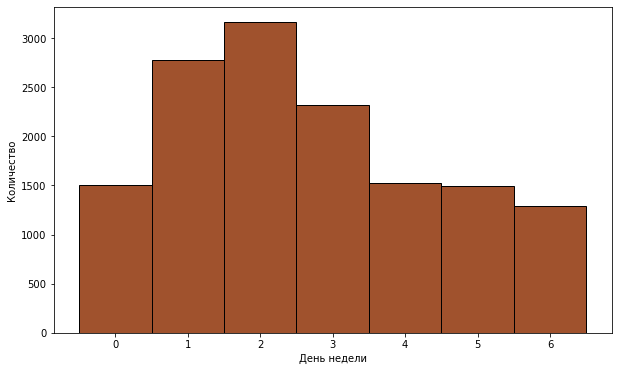

In [40]:
plt.figure(figsize=(10, 6))
plt.hist(train_data_10users['day_of_week'], color='sienna',edgecolor='black', align='left', bins = range(0,8))
plt.xlabel(u'День недели')
plt.ylabel(u'Количество')

**7. Постройте гистограммы распределения дня недели, в который началась сессия (*day_of_week*) для каждого из 10 пользователей по отдельности. Используйте *subplots*, чтоб разместить все 10 картинок на одной большой. Измените метки по оси *X* на ['Пн', 'Вт', 'Ср', 'Чт', 'Пт', 'Сб', 'Вс'] – метод *set_xticklabels*. Пометьте легендой каждую картинку, на легенде должно быть написано имя пользователя. Для каждого пользователя раскрасьте гистограмму его/ее цветом (*color_dic*). Подпишите по-русски название каждой из 10 гистограмм.**

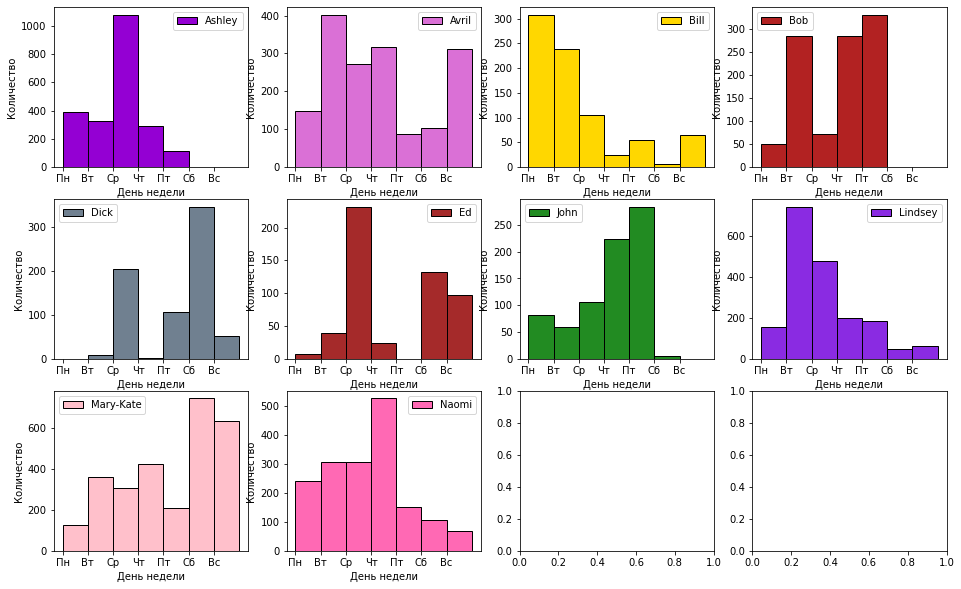

In [47]:
   
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 10))
row, column = 0, 0
# как вариант, можно и по-другому
for idx, (user, sub_df) in  enumerate(train_data_10users.groupby(['target'])): 
    axes[row, column].hist(sub_df['day_of_week'],edgecolor='black', color=color_dic[user], bins=range(0, 8))
    axes[row, column].set_xlabel(u'День недели')
    axes[row, column].set_ylabel(u'Количество')
    axes[row, column].set_xticks(range(0, 7))
    axes[row, column].set_xticklabels([u'Пн', u'Вт', u'Ср', u'Чт', u'Пт', u'Сб', u'Вс'])
    axes[row, column].legend([user])
    
    column += 1
    if column == 4:
        column = 0
        row += 1

**8. Сделайте выводы про каждого пользователя по построенным графикам.**

**Ashley**: посещает в среднем около 8-9 уникальных сайтов за сессию; обычно сёрфит утром и в обед; только в будние дни (в среду пик активности)

**Avril**: посещает в среднем около 6 уникальных сайтов за сессию; обычно сёрфит в обед и сразу после работы; пик активности середина рабочей недели и вс

**Bill**: посещает в среднем около 8-9 уникальных сайтов за сессию; обычно сёрфит утром и в обед; пик активности приходится на начало рабочей недели

**Bob**: посещает в среднем около 6-7 уникальных сайтов за сессию; обычно сёрфит утром и в обед; только в будние дни

**Dick**: равномерное распределение, кроме пн и вт; обычно сёрфит утром, днём и вечером; выходные и середина недели

**Ed**: посещает в среднем около 7-8 уникальных сайтов за сессию; равномерно, пик после обеда; выходные и середина недели

**John**: посещает в среднем около 6-7 уникальных сайтов за сессию; в течение рабочего дня; в основном будние дни с увеличением к пятнице

**Lindsey**: посещает в среднем около 7-8 уникальных сайтов за сессию; в течении рабочего дня с пиком в обед; пик в вт-ср

**Mary-Kate**: равномерное распределение, кроме пн и вт; равномерно; чаще в выходные

**Naomi**: посещает в среднем около 6-7 уникальных сайтов за сессию; в обед и поздний вечер; чаще в рабочие дни

**Загрузите сохраненный ранее в pickle-файл частотный словарь сайтов для 10 пользователей. **

In [48]:
with open(os.path.join(PATH_TO_DATA, 'site_freq_10users.pkl'), 'rb') as f:
    site_freq_10 = pickle.load(f)

**Определите топ-10 самых посещаемых сайтов (*top10_sites*) и соответствующие кол-ва посещений (*top10_freqs*).**

In [49]:
site_freq_10_sorted = sorted(site_freq_10.items(), key=lambda x: x[1][1], reverse=True)

top10_ids = [x[1][0] for x in site_freq_10_sorted[:10]]
top10_freqs = [x[1][1] for x in site_freq_10_sorted[:10]]
top10_sites = [x[0] for x in site_freq_10_sorted[:10]]

print('{:>5} {:>5}  {}'.format('ID', 'Freq', 'Site'))
for id_num, freq, site in zip(top10_ids, top10_freqs, top10_sites):
    print('{:5} {:5}  {}'.format(id_num, freq, site))

   ID  Freq  Site
  210  8300  s.youtube.com
   51  7813  www.google.fr
    4  5441  www.google.com
  183  4158  mail.google.com
   15  4141  www.facebook.com
   52  3758  apis.google.com
  700  3244  r3---sn-gxo5uxg-jqbe.googlevideo.com
  214  3094  r1---sn-gxo5uxg-jqbe.googlevideo.com
  187  2630  plus.google.com
  184  2089  accounts.google.com


**9. Нарисуйте *seaborn barplot*, показывающий частоты посещений топ-10 сайтов. Сделайте подписи сайтов вертикальными, иначе они сливаются (*xticks*).**

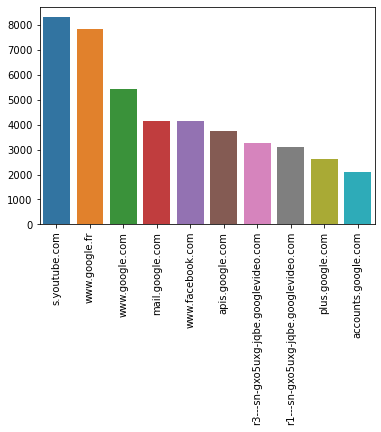

In [50]:
ax = sns.barplot(top10_sites, top10_freqs)
ax.set_xticklabels(top10_sites, rotation=90);

## Часть 3. Дальнейшее построение признаков

Это задание творческое, тут надо придумать, как еще учесть время посещения веб-страниц и прочие признаки. 

На следующей неделе мы будем использовать "мешок" сайтов  для классификации сессий по принадлежности разным пользователям, а эти новые признаки, которые Вы сейчас создадите, потом добавим и посмотрим, улучшается ли модель. Поэтому можно их создать в виде отдельных матриц и сохранить их также отдельно.  

В этой части задания Вы можете построить и визуально исследовать самые разные признаки (ничто фантазию не ограничивает):
- год, месяц и день начала сессии
- час начала сессии (с учетом года, месяца и дня)
- время суток
- среднее время пребывания на сайте, посчитать можно, скажем, для топ-30 популярных сайтов
- индикаторы посещения популярных сайтов (скажем, тоже для топ-30 популярных сайтов)
- частота посещения Facebook
- ...

**Напишите функцию для создания новых признаков и примените ее к исходным данным – каталогам с 10 и 150 файлами. Сделайте это только для набора данных, полученного с параметрами *session_length=10* и *window_size=10*. Сериализуйте полученные матрицы с помощью pickle. Функция может возвращать как только новые признаки, так и старые с новыми. При этом сигнатура функции может быть другой – тут уже свобода выбора.**

In [51]:
def convert_hour_to_day_period(hour):
    if 0 <= hour < 6: return 1
    elif 6 <= hour < 12: return 2
    elif 12 <= hour < 18: return 3
    elif 18 <= hour <=24: return 4
    else: return print('Timestamp hour is not valid!')
    
# Day period feature
def feature_day_period(df):
    df_new = pd.DataFrame()
    df_new['day_period'] = df['start_hour'].apply(convert_hour_to_day_period)
    return df_new['day_period']

# Top sites visit indicators feature
def feature_top_sites_indicator(df, site_freq, num_of_top_sites):
    columns = [u'site1', u'site2', u'site3', u'site4', u'site5',
               u'site6', u'site7', u'site8', u'site9', u'site10']
    feature = pd.DataFrame()
    for site, (site_id, _) in site_freq[:num_of_top_sites]:
        feature_name = 'site_ind_' + str(site_id)
        site_indicator = []
        for session in df[columns].values:
            if site_id in session:
                site_indicator.append(1)
            else: 
                site_indicator.append(0)
        feature[feature_name] = site_indicator
    return feature

# Top sites visit timespan feature
def feature_top_sites_timespan(df, site_freq, num_of_top_sites):
    feature = pd.DataFrame()
    for site, (site_id, _) in site_freq[:num_of_top_sites]:
        columns = [u'site1', u'site2', u'site3', u'site4', u'site5', 
                   u'site6', u'site7', u'site8', u'site9', u'site10']
        feature_name = 'site_t_' + str(site_id)
        site_timespan = []
        for i, session in enumerate(df[columns].values):
            time = 0
            for j, site in enumerate(session):
                if site == site_id:
                    col = 'time_diff' + str(j + 1)
                    time += df[col][i]
            site_timespan.append(time)
        feature[feature_name] = site_timespan
    return feature

# Tf-idf vectorizer feature
def feature_sites_for_tf_idf(df):
    columns = [u'site1', u'site2', u'site3', u'site4', u'site5',
               u'site6', u'site7', u'site8', u'site9', u'site10']
    feature = []
    for session in df[columns].values:
        feature.append(' '.join(map(str, list(session))))
    return pd.DataFrame(feature, columns=['sites_for_tf_idf'])


def create_new_features(df, site_freq_path, feature_names, num_of_top_sites=30):
    with open(site_freq_path, 'rb') as f:
        site_freq_full = pickle.load(f)
        
    site_freq_top = sorted(site_freq_full.items(), key=lambda x: x[1][1], reverse=True)[:num_of_top_sites]
    
    df_feature = pd.DataFrame()
    
    if 'day_period' in feature_names:
        df1 = feature_day_period(df)
        df_feature = pd.concat([df_feature, df1], axis=1)
    
    if 'site_ind' in feature_names:
        df2 = feature_top_sites_indicator(df, site_freq_top, num_of_top_sites)
        df_feature = pd.concat([df_feature, df2], axis=1)
        
    if 'site_t' in feature_names:
        df3 = feature_top_sites_timespan(df, site_freq_top, num_of_top_sites)
        df_feature = pd.concat([df_feature, df3], axis=1)
        
    if 'sites_for_tf_idf' in feature_names:
        df4 = feature_sites_for_tf_idf(df)
        df_feature = pd.concat([df_feature, df4], axis=1)
        
    return df_feature


def feature_engineering(site_freq_path, feature_names,
                        path_to_csv_files=None, df=None, session_length=10, window_size=10, set_option=0):
    
    '''
    set_option: 0 - create dataframe with cool features
                1 - create dataframe without cool features
                2 - create only cool features
                3 - add cool features to existing dataframe
    '''
    
    if (set_option == 0) and (df == None):
        return prepare_train_set_with_fe(path_to_csv_files, site_freq_path, feature_names,
                              session_length=session_length, window_size=window_size)
    
    elif (set_option == 1) and (df == None):
        df = prepare_train_set_with_fe(path_to_csv_files, site_freq_path, feature_names,
                              session_length=session_length, window_size=window_size)
        df_new = create_new_features(df, site_freq_path, feature_names, num_of_top_sites=30)
        return pd.concat([df, df_new], axis=1)
    
    elif (set_option == 2):
        return create_new_features(df, site_freq_path, feature_names, num_of_top_sites=30)
    
    elif (set_option == 3):
        df_new = create_new_features(df, site_freq_path, feature_names, num_of_top_sites=30)
        return pd.concat([df, df_new], axis=1)
    
    else:
        print('Wrong input!')
        return None

In [ ]:
with open(os.path.join(PATH_TO_DATA, 
                       'selected_features_10users.pkl'), 'wb') as selected_features_10users_pkl:
    pickle.dump(selected_features_10users, selected_features_10users_pkl, 
                protocol=2)
with open(os.path.join(PATH_TO_DATA, 
                       'selected_features_150users.pkl'), 'wb') as selected_features_150users_pkl:
    pickle.dump(selected_features_150users, selected_features_150users_pkl, 
                protocol=2)

### Критерии оценки работы (только для Peer Review в специализации):
- Верно ли отображена гистограмма session_timespan из п. 1? (max. 3 балла)
- Верно ли отображена гистограмма #unique_sites из п. 2? (max. 3 балла)
- Верно ли отображены гистограммы #unique_sites по каждому пользователю из п. 3? (max. 6 баллов)
- Верно ли отображена гистограмма start_hour из п. 4? (max. 3 балла)
- Верно ли отображены гистограммы start_hour по каждому пользователю из п. 5? (max. 6 баллов)
- Верно ли отображена гистограмма day_of_week из п. 6? (max. 3 балла)
- Верно ли отображены гистограммы day_of_week по каждому пользователю из п. 7? (max. 6 баллов)
- Насколько сделанные выводы в п. 8 соответствуют построенным картинкам? (max. 6 баллов)
- Верно ли отображен barplot для 10 популярных сайтов из п. 9? (max. 6 баллов)
- Правильно ли посчитана медианная продолжительность сессий в п. 10? (max. 3 балла)
- Правильно ли посчитан медианный день недели начала сессии в п. 11? (max. 3 балла)
- Правильно ли посчитан медианный час начала сессии в п. 12? (max. 3 балла)
- Правильно ли посчитано медианное значение числа уникальных сайтов в сессиях 150 пользователей п. 13? (max. 3 балла)
- Есть ли оригинальные построенные признаки и картинки к ним? Оцените также и качество картинок. (max. 8 баллов)

## Пути улучшения
Что еще можно добавить по 3 части проекта:
- IPython-widgets, интерактив и анимация (стоящие статьи по этому ремеслу – [раз](https://habrahabr.ru/post/308162/) и  [два](https://habrahabr.ru/company/ods/blog/323210/))
- можно попробовать изобразить исходные данные в некотором пространстве, например, Word2Vec, потом выделить главные компоненты или t-SNE  (только пользуйтесь эффективными реализациями типа [Multicore-TSNE](https://github.com/DmitryUlyanov/Multicore-TSNE), не Sklearn) и раскрасить по целевому классу. Но нет гарантий, что получится что-то значимо отличающееся от каши

На следующей неделе мы наконец приступим к обучению моделей классификации. 